In [1]:
# import
import os
import numpy as np
import scipy as sp
from scipy import stats
from sklearn.cluster import KMeans

# import plotting libraries
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})
plt.rcParams['svg.fonttype'] = 'none'
import seaborn as sns
from nilearn import datasets
from nilearn import plotting

# import network_control functions
from network_control.energies import ComputeControlEnergy, integrate_u
from network_control.energies import optimal_input as get_control_inputs
from network_control.metrics import ave_control
from network_control.utils import matrix_normalization, convert_states_str2float, normalize_state
from network_control.plotting import roi_to_vtx

In [2]:
# directory where data is stored
datadir = '/Users/lindenmp/Google-Drive-Penn/work/research_projects/control_package/data'
resultsdir = '/Users/lindenmp/Google-Drive-Penn/work/research_projects/control_package/results'
A_file = 'pnc_schaefer200_Am.npy'

In [3]:
# load A matrix
A = np.load(os.path.join(datadir, A_file))
n_nodes = A.shape[0]
print(A.shape)

(200, 200)


In [4]:
# normalize
A[np.eye(A.shape[0]).astype(bool)] = 0
version = 'continuous'
A_norm = matrix_normalization(A, version=version, c=1)

In [5]:
# load node-to-system mapping
system_labels = list(np.loadtxt(os.path.join(datadir, 'pnc_schaefer200_system_labels.txt'), dtype=str))

In [6]:
print(len(system_labels))
print(system_labels[:20])

200
['Vis', 'Vis', 'Vis', 'Vis', 'Vis', 'Vis', 'Vis', 'Vis', 'Vis', 'Vis', 'Vis', 'Vis', 'Vis', 'Vis', 'SomMot', 'SomMot', 'SomMot', 'SomMot', 'SomMot', 'SomMot']


In [7]:
# use list of system names to create states
states, state_labels = convert_states_str2float(system_labels)

In [8]:
print(type(state_labels), len(state_labels))
print(state_labels)

<class 'list'> 7
['Cont', 'Default', 'DorsAttn', 'Limbic', 'SalVentAttn', 'SomMot', 'Vis']


In [9]:
print(type(states), states.shape)
print(states)

<class 'numpy.ndarray'> (200,)
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 2 2 2 2 2 2 2
 2 2 2 2 2 2 4 4 4 4 4 4 4 4 4 4 4 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 2 2 2 2 2 2 2 2 2 2 2 2 2 4
 4 4 4 4 4 4 4 4 4 4 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [10]:
# extract initial state
x0 = states == state_labels.index('SalVentAttn')

# extract target state
xf = states == state_labels.index('Default')

In [11]:
# normalize state magnitude
x0 = normalize_state(x0)
xf = normalize_state(xf)

In [12]:
# specify a uniform full control: all nodes are control nodes
# and all control nodes are assigned equal control weight
B = np.eye(n_nodes)

In [13]:
# set parameters
T = 1 # time horizon
rho = 1 # mixing parameter for state trajectory constraint
S = np.eye(n_nodes) # nodes in state trajectory to be constrained

# get the state trajectory (x) and the control inputs (u)
x, u, n_err = get_control_inputs(A_norm, T, B, x0, xf, rho, S)

# check for state completion. We expect to see 0 here,
# which indicates no difference between the model at the end of the simulation at xf
print(np.round(np.sum(np.square(x[-1, :] - xf)), 8))

0.0


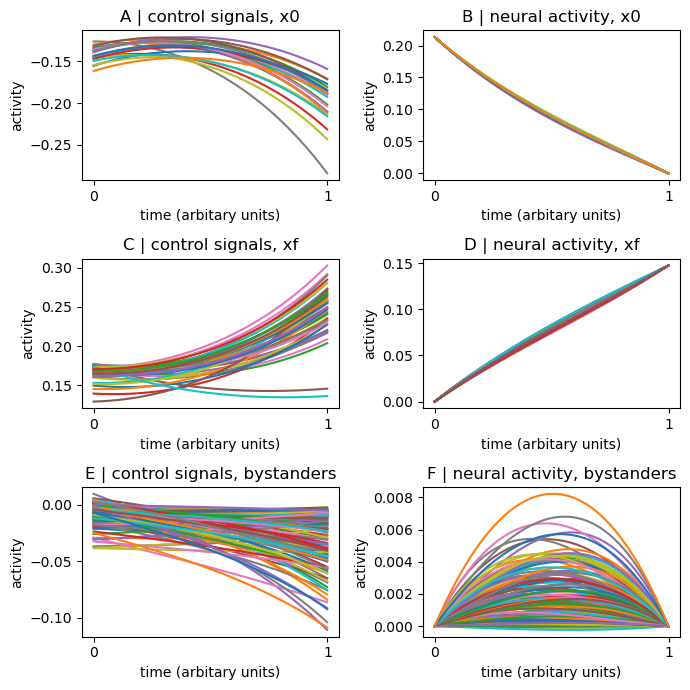

In [14]:
f, ax = plt.subplots(3, 2, figsize=(7, 7))
# plot control signals for initial state
ax[0, 0].plot(u[:, x0 != 0])
ax[0, 0].set_title('A | control signals, x0')
# plot state trajectory for initial state
ax[0, 1].plot(x[:, x0 != 0])
ax[0, 1].set_title('B | neural activity, x0')

# plot control signals for target state
ax[1, 0].plot(u[:, xf != 0])
ax[1, 0].set_title('C | control signals, xf')
# plot state trajectory for target state
ax[1, 1].plot(x[:, xf != 0])
ax[1, 1].set_title('D | neural activity, xf')

# plot control signals for bystanders
ax[2, 0].plot(u[:, np.logical_and(x0 == 0, xf == 0)])
ax[2, 0].set_title('E | control signals, bystanders')
# plot state trajectory for bystanders
ax[2, 1].plot(x[:, np.logical_and(x0 == 0, xf == 0)])
ax[2, 1].set_title('F | neural activity, bystanders')

for cax in ax.reshape(-1):
    cax.set_ylabel("activity")
    cax.set_xlabel("time (arbitary units)")
    cax.set_xticks([0, x.shape[0]])
    cax.set_xticklabels([0, T])

f.tight_layout()
f.savefig(os.path.join(resultsdir, 'plot_xu.svg'), dpi=600, bbox_inches='tight', pad_inches=0.01)
plt.show()

In [15]:
# integrate control inputs to get control energy
node_energy = integrate_u(u)

# summarize nodal energy
energy = np.sum(node_energy)

print(np.round(energy, 2))

2237.5
